# EE3-25 Deep Learning Coursework
*Miroslav Gasparek, Dept. of Bioengineering, Imperial College London*

*Last update: 20 March 2019*
The coursework for the Deep Learning course in the EE Department at Imperial College London. 

### Description
This coursework deals with the two-step training for the N-HPatches problem. In N-HPatches problem, we aim to generate a patch descriptor that is able to perform successfully tasks such as matching, retrieval or verification.
Contrary to classical HPatches dataset, in N-HPatches, images contain random non-smooth perturbations produced by a synthetic noise. This noise could be critical when training the descriptor, therefore, we introduce a denoising model that could help us to deal with those perturbations.  

We aim to minimize the noise in images before the second step, which is computing a feature vector, also called descriptor.

### Preliminary safety check

In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print()  
printm()


  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil

RAM Free: 12.9 GB  | Proc size: 332.1 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Cloning into repository, downloading and extracting data

In [0]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
  
# Change directory
%cd /content/keras_triplet_descriptor

Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 181 (delta 0), reused 1 (delta 0), pack-reused 178
Receiving objects: 100% (181/181), 149.87 MiB | 19.50 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (69/69), done.
/content/keras_triplet_descriptor


In [0]:

# Download data (zipped format)
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip

--2019-03-21 22:50:26--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 185.235.236.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-21 22:50:27--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-21 22:50:27--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.bo

In [0]:
# Extract data (unzip)
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

## Importing necessary modules

In [0]:
# Import necessary Python modules and tensorflow
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# Import keras and appropriate modules
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  
from keras.layers import GlobalAveragePooling2D, AveragePooling2D
from keras.utils import np_utils
from keras.utils import plot_model


# Import callbacks
from keras.callbacks import ReduceLROnPlateau
# Import the appropriate module for callbacks
from keras.callbacks import Callback
# Import the module for ROC and AUC 
from sklearn.metrics import roc_auc_score
from keras.callbacks import ModelCheckpoint

# Import ResNet50
from keras.applications.resnet50 import ResNet50

# Import modules specific to the task
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

In [0]:
# Fix the seeds of the pseudo-random number generators to get the reproducible results
# This should enable us to have the same results whenever the algorithm is run
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

## Loading the appropriate data

In [0]:
# Load the data with the appropriate split
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

## Define the triplet loss

In [0]:
# Define the triplet loss metrics
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)




## Improved denoising model definition

In [0]:
def get_denoise_model_UNet(shape):
   
  # Architecture inspired by UNet, but some layers are removed, only the optimal
  # architecture is left
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  # This is the bottle-neck of the network
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(0.5)(conv5)

  ## Now the decoder starts

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

  conv10 = Conv2D(1, 3,  padding = 'same')(conv9)

  deeper_net = Model(inputs = inputs, outputs = conv10)
  
#   deeper_net.summary()
  
  return deeper_net

## Improved descriptor model definition

In [0]:
# Define the residual identity block
def identity_block(X,k_size, filters, stage, block):
  
  """Residual identity block implementation.
  """
  
  # Define the name basis for the identification
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  # Get the filters for the particular layers
  F1, F2, F3 = filters
  
  # Save the input for later to be added back
  X_shortcut = X

  ### MAIN PATH ###
  # The first layer of the main path
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
             name= conv_name_base + '2a')(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  # The second layer of the main path
  X = Conv2D(filters=F2, kernel_size=(k_size, k_size), strides=(1,1), padding='same',
             name=conv_name_base + '2b')(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
  X = Activation('relu')(X)

  # The third layer of the main path
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
             name=conv_name_base + '2c')(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

  # Finally, add the input to the output of the residual block
  # and pass it through the ReLU activation
  X = keras.layers.Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

# Define the residual network convolutional block
def convolutional_block(X,k_size, filters, stage, block, st=2):
  
  """Residual convolutional block implementation.
     To be used if the input and output dimensions do not match up.
     In such case, the convolutional block is added to the shortcut path.
  """
  
  # Define the name basis for the identification
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  # Get the filters for the particular layers
  F1, F2, F3 = filters
  
  # Save the input for later to be added back
  X_shortcut = X

  ### MAIN PATH ###
  # The first layer of the main path
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(st, st), padding='valid',
             name= conv_name_base + '2a')(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  # The second layer of the main path
  X = Conv2D(filters=F2, kernel_size=(k_size, k_size), strides=(1,1), padding='same',
             name=conv_name_base + '2b')(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
  X = Activation('relu')(X)

  # The third layer of the main path
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
             name=conv_name_base + '2c')(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

  ### SHORTCUT PATH ###
  # Shortcut path contains a convolutional layer with Batch Normalization
  X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(st,st),
                     name=conv_name_base + '1')(X_shortcut)
  X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
  
  # Finally, add the input to the output of the residual block
  # and pass it through the ReLU activation
  X = keras.layers.Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X


# Define the descriptor network
def get_descriptor_model_improved(shape):
  
  '''Architecture combines the intial branching block inspired by the 
  inception net, and several residual blocks, inspired by the ResNet.
  Full ResNet was considered, but it was found out to give too much burden
  for the training from scratch.'''
  
    # The inputs must have the appropriate size
  # Input size must be 32x32x1 to match the pictures
  X_input = Input(shape)
  
  # Define weight initializer
  init_weights = keras.initializers.he_normal()
  
  # The first two convolutional layers
  X = Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=shape, kernel_initializer=init_weights, name='conv1a')(X_input)
  X = BatchNormalization(axis = -1)(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=shape, kernel_initializer=init_weights, name='conv1b')(X)
  X = BatchNormalization(axis = -1)(X)
  X = Activation('relu')(X)

  # The second convolutional layer - first branch
  X1 = Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer=init_weights,name='conv2a')(X)
  X1 = BatchNormalization(axis = -1)(X1)
  X1 = Activation('relu')(X1)
  
  X1 = Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer=init_weights,name='conv2b')(X)
  X1 = BatchNormalization(axis = -1)(X1)
  X1 = Activation('relu')(X1)  
  
  # The second convolutional layer - second branch
  X2 = Conv2D(filters=8, kernel_size=(1,1), padding='same', kernel_initializer=init_weights, name='conv3a')(X)
  X2 = BatchNormalization(axis = -1)(X2)
  X2 = Activation('relu')(X2)
  
  X2 = Conv2D(filters=8, kernel_size=(3,3), padding='same', kernel_initializer=init_weights, name='conv3b')(X2)
  X2 = BatchNormalization(axis = -1)(X2)
  X2 = Activation('relu')(X2)

  X2 = Conv2D(filters=32, kernel_size=(1,1), padding='same', kernel_initializer=init_weights, name='conv3c')(X2)
  X2 = BatchNormalization(axis = -1)(X2)
  X2 = Activation('relu')(X2)
  
  X = keras.layers.Add()([X1,X2])
  
  # The convolutional and indentity blocks, inspired by
  # https://engmrk.com/residual-networks-resnets/  
  X = convolutional_block(X, k_size=3, filters=[8, 8, 32], stage=4, block='a',st=2)
  X = identity_block(X,k_size=3, filters = [8, 8, 32], stage=4, block='b')
  X = identity_block(X,k_size=3, filters = [8, 8, 32], stage=4, block='c')

  X = Dropout(0.3)(X)

  X = Conv2D(filters=128, kernel_size=(8,8), padding='valid', kernel_initializer=init_weights, name='conv4')(X)
  X = BatchNormalization(axis = -1)(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters=128, kernel_size=(8,8), strides=(2,2), padding='valid', kernel_initializer=init_weights, name='conv5')(X)
  X = BatchNormalization(axis = -1)(X)
  X = Activation('relu')(X)
    
  
#   # Final descriptor reshape
  X = Reshape((128,))(X)
 
  # Create the model
  model = Model(inputs=X_input, outputs=X, name='improved')
  
  return model

  



In [0]:
# Verify the syntax of the model
shape=(32,32,1)
descriptor_model_improved_loaded = get_descriptor_model_improved(shape)
descriptor_model_improved_loaded.summary()
plot_model(descriptor_model_improved_loaded, to_file='model_loaded.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv1a (Conv2D)                 (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv1a[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activat

In [0]:
denoise_model_UNet_loaded = get_denoise_model_UNet(shape)
denoise_model_UNet_loaded.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 128)  73856       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

## Denoising model training and evaluation

### Training

In [0]:
# Generating the training and validation samples for the denoising network
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
# denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
# denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


In [0]:
# Define the class 'Histories' that will get us
# Callback for the losses and accuracies
class Histories(Callback):

    def on_train_begin(self,logs={}):
        self.losses = []
        self.mean_absolute_errors = []
        self.accuracies = []
        self.auroc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.mean_absolute_errors.append(logs.get('mae'))
        self.accuracies.append(logs.get('accuracy'))
        self.auroc.append(logs.get('auroc'))
        
# Define the function auc for calculation of AUC
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)



In [0]:
# Define the shape of the input
shape = (32, 32, 1)

# Get the model for UNet net
denoise_model_UNet = get_denoise_model_UNet(shape)



In [0]:
from keras.callbacks import ReduceLROnPlateau
# Add the callback for the Reducing of the LR on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.0001, min_delta = 0.01)

from keras.callbacks import ModelCheckpoint
## Here we define the checkpoint callback. We first give the name it will use 
## to save the model. We also specify what metric should monitor, in this case
## the validation loss (it could be validation accuracy too for example)
## save_best_only means that the models will only be save when the monitored 
## metric improves with respect to the past best one
checkpoint = ModelCheckpoint('denoise_model-{epoch:03d}.h5', verbose=1, 
                             monitor='val_loss',save_best_only=True)

In [0]:
# Make the callback for the UNet network's losses
histories_denoise_UNet = Histories()

# Set the algorithm hyperparameters for the denoising network
adam = keras.optimizers.Adam(lr=0.001)
denoise_model_UNet.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
epochs = 1 # Train for 20 epochs!!!
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
for e in range(epochs):
  denoise_history_UNet = denoise_model_UNet.fit_generator(generator=denoise_generator, 
                                                          epochs=20, verbose=1, 
                                                          validation_data=denoise_generator_val,
                                                          callbacks=[histories_denoise_UNet, reduce_lr, checkpoint])
  ### Saves optimizer and weights
  denoise_model_UNet.save('denoise_UNet_long.h5') 
  ### Uploads files to external hosting
  !curl -F "file=@denoise_UNet_long.h5" https://file.io

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
1440/1440 [==============================] - 238s 165ms/step - loss: 325537.2306 - mean_squared_error: 325537.2306 - val_loss: 83.2755 - val_mean_squared_error: 83.2755

Epoch 00001: val_loss improved from inf to 83.27549, saving model to denoise_model-001.h5
Epoch 2/20
1440/1440 [==============================] - 232s 161ms/step - loss: 69.8541 - mean_squared_error: 69.8541 - val_loss: 74.9570 - val_mean_squared_error: 74.9570

Epoch 00002: val_loss improved from 83.27549 to 74.95695, saving model to denoise_model-002.h5
Epoch 3/20
1440/1440 [==============================] - 231s 161ms/step - loss: 65.0444 - mean_squared_error: 65.0444 - val_loss: 78.7862 - val_mean_squared_error: 78.7862

Epoch 00003: val_loss did not improve from 74.95695
Epoch 4/20
1440/1440 [==============================] - 232s 161ms/step - loss: 56.6959 - mean_squared_error: 56.6959 - val_loss: 65.7079 - val_mean_squared_error: 65.7079

Epoch 00004: va

### Evaluation

In [0]:
def plot_history(history, metric = None, ylimit=None, titlestring='Model Loss ',
                 parameters=''):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1)
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Train', 'Val'])
    except:
      pass
    axes[0].set_title('{:s}'.format(metric))
    axes[0].set_ylabel('{:s}'.format(metric))
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Train', 'Val'])
    except:
      pass
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Training', 'Validation'])
      
      if ylimit != None:
        plt.ylim(ylimit)

    except:
      pass
    plt.title(titlestring + '\n'+parameters,
              fontsize=18)
    plt.ylabel('Loss',fontsize=15)
    plt.xlabel('Epoch', fontsize=15)

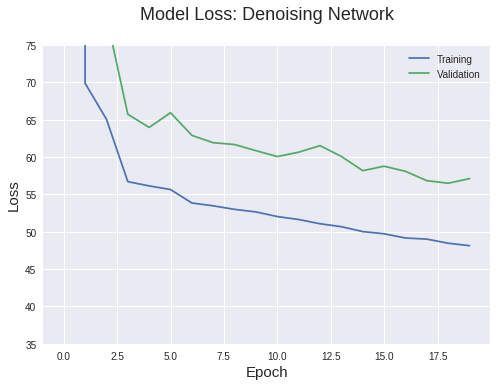

In [0]:
plot_history(denoise_history_UNet, ylimit=[35,75],
             titlestring='Model Loss: Denoising Network')

In [0]:
def plot_lc(*histories, titlestring='Training Loss', legstr=['Baseline'],
            loss_form='',
            parameters='',
            ylimit=[0,200]):
  """Function plots the learning curve as a function of no. of iterations."""
  
  fig = plt.figure()
  fig.set_size_inches(6, 6)
  axes = plt.axes()
  
  for ind in range(len(histories)):
    axes.plot(histories[ind].losses)
    
  axes.legend(legstr,fontsize=15)
  axes.set_title(titlestring +
                 '\n' + parameters,
                 fontsize=20)
  axes.set_ylabel(loss_form + ' Loss',fontsize=15)
  axes.set_xlabel('Iterations',fontsize=15)
  axes.set_ylim(ylimit)

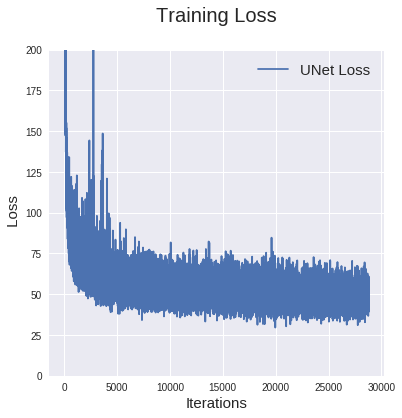

In [0]:
plot_lc(histories_denoise_UNet, 
        legstr=['UNet Loss'])

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


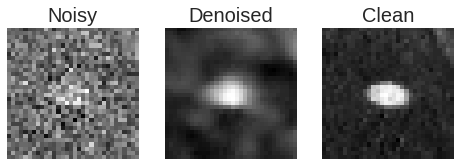

In [0]:
# Plot the UNet denoising results
plot_denoise(denoise_model_UNet)

## Improved descriptor model training

In [0]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_UNet, use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=50000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=5000)

Using denoised patches
100%|██████████| 116/116 [00:34<00:00,  3.43it/s]
Denoising patches...
100%|██████████| 15589/15589 [23:06<00:00, 11.24it/s]


100%|██████████| 50000/50000 [00:00<00:00, 90281.28it/s]


Using denoised patches
100%|██████████| 116/116 [00:15<00:00,  7.37it/s]
Denoising patches...
100%|██████████| 9525/9525 [14:05<00:00, 11.34it/s]


100%|██████████| 5000/5000 [00:00<00:00, 75366.36it/s]


In [0]:
# Add the callback for the Reducing of the LR on plateau
reduce_lr_desc = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.0001, min_delta = 0.01)

## Define the checkpoint callback. We first give the name it will use 
## to save the model. We also specify what metric should monitor, in this case
## the validation loss (it could be validation accuracy too for example)
## save_best_only means that the models will only be save when the monitored 
## metric improves with respect to the past best one
checkpoint_desc = ModelCheckpoint('descriptor-{epoch:03d}.h5', verbose=1, 
                             monitor='val_loss',save_best_only=True)

In [0]:
# Define the callback for the learning curve for improved network architecture
histories_descriptor_improved = Histories()

# Set up the descriptor model and set its hyperparameters
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model_improved = get_descriptor_model_improved(shape)
ea = descriptor_model_improved(xa)
ep = descriptor_model_improved(xp)
en = descriptor_model_improved(xn)

# Defines the loss calculated in the Lambda layer
loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip_improved = Model(inputs=[xa, xp, xn], outputs=loss)
adam = keras.optimizers.Adam(lr=0.001) # Define the Adam optimizer
descriptor_model_trip_improved.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
                                                                                        

In [0]:
# Train the baseline descriptor model and save weights afterwards
epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

for e in range(epochs):
  
  descriptor_history_improved = descriptor_model_trip_improved.fit_generator(generator=training_generator,
                                                                             epochs=20,
                                                                             verbose=1, 
                                                           validation_data=val_generator,
                                                           callbacks=[histories_descriptor_improved,
                                                                      reduce_lr_desc,
                                                                      checkpoint_desc])
  
  ### Saves optimizer and weights
  descriptor_model_trip_improved.save('descriptor_impr.h5') 
  ### Uploads files to external hosting
  !curl -F "file=@descriptor_impr_new.h5" https://file.io

Epoch 1/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.3023 - mean_absolute_error: 0.3023

100%|██████████| 50000/50000 [00:01<00:00, 41199.67it/s]


1000/1000 [==============================] - 140s 140ms/step - loss: 0.3021 - mean_absolute_error: 0.3021 - val_loss: 0.2813 - val_mean_absolute_error: 0.2813


100%|██████████| 5000/5000 [00:00<00:00, 48532.60it/s]



Epoch 00001: val_loss improved from inf to 0.28125, saving model to descriptor-001.h5
Epoch 2/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.1921 - mean_absolute_error: 0.1921

100%|██████████| 50000/50000 [00:01<00:00, 48415.23it/s]


1000/1000 [==============================] - 119s 119ms/step - loss: 0.1920 - mean_absolute_error: 0.1920 - val_loss: 0.2271 - val_mean_absolute_error: 0.2271

Epoch 00002: val_loss improved from 0.28125 to 0.22707, saving model to descriptor-002.h5


100%|██████████| 5000/5000 [00:00<00:00, 66797.21it/s]


Epoch 3/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.1660 - mean_absolute_error: 0.1660

100%|██████████| 50000/50000 [00:00<00:00, 51887.00it/s]


1000/1000 [==============================] - 118s 118ms/step - loss: 0.1660 - mean_absolute_error: 0.1660 - val_loss: 0.1921 - val_mean_absolute_error: 0.1921

Epoch 00003: val_loss improved from 0.22707 to 0.19211, saving model to descriptor-003.h5


100%|██████████| 5000/5000 [00:00<00:00, 67761.11it/s]


Epoch 4/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.1523 - mean_absolute_error: 0.1523

100%|██████████| 50000/50000 [00:01<00:00, 40283.39it/s]


1000/1000 [==============================] - 118s 118ms/step - loss: 0.1522 - mean_absolute_error: 0.1522 - val_loss: 0.1852 - val_mean_absolute_error: 0.1852


100%|██████████| 5000/5000 [00:00<00:00, 45945.24it/s]



Epoch 00004: val_loss improved from 0.19211 to 0.18520, saving model to descriptor-004.h5
Epoch 5/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.1306 - mean_absolute_error: 0.1306

100%|██████████| 50000/50000 [00:00<00:00, 53013.10it/s]


1000/1000 [==============================] - 115s 115ms/step - loss: 0.1307 - mean_absolute_error: 0.1307 - val_loss: 0.1697 - val_mean_absolute_error: 0.1697

Epoch 00005: val_loss improved from 0.18520 to 0.16965, saving model to descriptor-005.h5


100%|██████████| 5000/5000 [00:00<00:00, 35173.07it/s]


Epoch 6/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.1258 - mean_absolute_error: 0.1258

100%|██████████| 50000/50000 [00:00<00:00, 51804.71it/s]


1000/1000 [==============================] - 115s 115ms/step - loss: 0.1257 - mean_absolute_error: 0.1257 - val_loss: 0.1586 - val_mean_absolute_error: 0.1586

Epoch 00006: val_loss improved from 0.16965 to 0.15861, saving model to descriptor-006.h5


100%|██████████| 5000/5000 [00:00<00:00, 78003.96it/s]


Epoch 7/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.1214 - mean_absolute_error: 0.1214

100%|██████████| 50000/50000 [00:00<00:00, 52477.84it/s]


1000/1000 [==============================] - 114s 114ms/step - loss: 0.1214 - mean_absolute_error: 0.1214 - val_loss: 0.1549 - val_mean_absolute_error: 0.1549

Epoch 00007: val_loss improved from 0.15861 to 0.15486, saving model to descriptor-007.h5


100%|██████████| 5000/5000 [00:00<00:00, 64444.08it/s]


Epoch 8/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.1179 - mean_absolute_error: 0.1179

100%|██████████| 50000/50000 [00:00<00:00, 51354.72it/s]


1000/1000 [==============================] - 116s 116ms/step - loss: 0.1179 - mean_absolute_error: 0.1179 - val_loss: 0.1377 - val_mean_absolute_error: 0.1377

Epoch 00008: val_loss improved from 0.15486 to 0.13767, saving model to descriptor-008.h5


100%|██████████| 5000/5000 [00:00<00:00, 70963.85it/s]


Epoch 9/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.1192 - mean_absolute_error: 0.1192

100%|██████████| 50000/50000 [00:00<00:00, 55659.32it/s]


1000/1000 [==============================] - 116s 116ms/step - loss: 0.1192 - mean_absolute_error: 0.1192 - val_loss: 0.1539 - val_mean_absolute_error: 0.1539

Epoch 00009: val_loss did not improve from 0.13767
Epoch 10/20
   3/1000 [..............................] - ETA: 2:26 - loss: 0.1209 - mean_absolute_error: 0.1209

  0%|          | 0/5000 [00:00<?, ?it/s]



100%|██████████| 5000/5000 [00:00<00:00, 57064.12it/s]

   4/1000 [..............................] - ETA: 2:37 - loss: 0.1221 - mean_absolute_error: 0.1221

 999/1000 [============================>.] - ETA: 0s - loss: 0.1127 - mean_absolute_error: 0.1127

100%|██████████| 50000/50000 [00:00<00:00, 58610.28it/s]


1000/1000 [==============================] - 114s 114ms/step - loss: 0.1126 - mean_absolute_error: 0.1126 - val_loss: 0.1503 - val_mean_absolute_error: 0.1503

Epoch 00010: val_loss did not improve from 0.13767
Epoch 11/20
   2/1000 [..............................] - ETA: 2:27 - loss: 0.1462 - mean_absolute_error: 0.1462

  0%|          | 0/5000 [00:00<?, ?it/s]

   3/1000 [..............................] - ETA: 2:55 - loss: 0.1562 - mean_absolute_error: 0.1562

100%|██████████| 5000/5000 [00:00<00:00, 57311.76it/s]


 999/1000 [============================>.] - ETA: 0s - loss: 0.1118 - mean_absolute_error: 0.1118

100%|██████████| 50000/50000 [00:00<00:00, 56626.75it/s]


1000/1000 [==============================] - 114s 114ms/step - loss: 0.1117 - mean_absolute_error: 0.1117 - val_loss: 0.1477 - val_mean_absolute_error: 0.1477

Epoch 00011: val_loss did not improve from 0.13767
Epoch 12/20
   2/1000 [..............................] - ETA: 2:25 - loss: 0.0764 - mean_absolute_error: 0.0764

  0%|          | 0/5000 [00:00<?, ?it/s]

   3/1000 [..............................] - ETA: 2:55 - loss: 0.0890 - mean_absolute_error: 0.0890

100%|██████████| 5000/5000 [00:00<00:00, 52295.97it/s]


 999/1000 [============================>.] - ETA: 0s - loss: 0.1116 - mean_absolute_error: 0.1116

100%|██████████| 50000/50000 [00:00<00:00, 53110.08it/s]


1000/1000 [==============================] - 114s 114ms/step - loss: 0.1116 - mean_absolute_error: 0.1116 - val_loss: 0.1356 - val_mean_absolute_error: 0.1356

Epoch 00012: val_loss improved from 0.13767 to 0.13559, saving model to descriptor-012.h5


100%|██████████| 5000/5000 [00:00<00:00, 88137.48it/s]


Epoch 13/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.1063 - mean_absolute_error: 0.1063

100%|██████████| 50000/50000 [00:00<00:00, 56305.46it/s]


1000/1000 [==============================] - 113s 113ms/step - loss: 0.1063 - mean_absolute_error: 0.1063 - val_loss: 0.1594 - val_mean_absolute_error: 0.1594

Epoch 00013: val_loss did not improve from 0.13559
Epoch 14/20
   3/1000 [..............................] - ETA: 2:07 - loss: 0.1485 - mean_absolute_error: 0.1485

100%|██████████| 5000/5000 [00:00<00:00, 49869.50it/s]

   4/1000 [..............................] - ETA: 2:32 - loss: 0.1365 - mean_absolute_error: 0.1365

 999/1000 [============================>.] - ETA: 0s - loss: 0.1067 - mean_absolute_error: 0.1067

100%|██████████| 50000/50000 [00:02<00:00, 23341.90it/s]


1000/1000 [==============================] - 115s 115ms/step - loss: 0.1068 - mean_absolute_error: 0.1068 - val_loss: 0.1470 - val_mean_absolute_error: 0.1470

Epoch 00014: val_loss did not improve from 0.13559
Epoch 15/20
   3/1000 [..............................] - ETA: 2:30 - loss: 0.1519 - mean_absolute_error: 0.1519

  0%|          | 0/5000 [00:00<?, ?it/s]

   4/1000 [..............................] - ETA: 2:23 - loss: 0.1450 - mean_absolute_error: 0.1450

100%|██████████| 5000/5000 [00:00<00:00, 51117.88it/s]


 999/1000 [============================>.] - ETA: 0s - loss: 0.1082 - mean_absolute_error: 0.1082

100%|██████████| 50000/50000 [00:00<00:00, 54525.88it/s]


1000/1000 [==============================] - 114s 114ms/step - loss: 0.1082 - mean_absolute_error: 0.1082 - val_loss: 0.1501 - val_mean_absolute_error: 0.1501

Epoch 00015: val_loss did not improve from 0.13559
Epoch 16/20
   3/1000 [..............................] - ETA: 2:08 - loss: 0.1021 - mean_absolute_error: 0.1021

  0%|          | 0/5000 [00:00<?, ?it/s]

   4/1000 [..............................] - ETA: 2:30 - loss: 0.0912 - mean_absolute_error: 0.0912

100%|██████████| 5000/5000 [00:00<00:00, 47704.50it/s]


 999/1000 [============================>.] - ETA: 0s - loss: 0.1072 - mean_absolute_error: 0.1072

100%|██████████| 50000/50000 [00:00<00:00, 53122.62it/s]


1000/1000 [==============================] - 113s 113ms/step - loss: 0.1073 - mean_absolute_error: 0.1073 - val_loss: 0.1436 - val_mean_absolute_error: 0.1436

Epoch 00016: val_loss did not improve from 0.13559
Epoch 17/20
   3/1000 [..............................] - ETA: 2:28 - loss: 0.0902 - mean_absolute_error: 0.0902

 96%|█████████▌| 4808/5000 [00:00<00:00, 48078.78it/s]

   4/1000 [..............................] - ETA: 2:27 - loss: 0.0989 - mean_absolute_error: 0.0989

100%|██████████| 5000/5000 [00:00<00:00, 48042.74it/s]


 999/1000 [============================>.] - ETA: 0s - loss: 0.1077 - mean_absolute_error: 0.1077

100%|██████████| 50000/50000 [00:00<00:00, 55466.99it/s]


1000/1000 [==============================] - 113s 113ms/step - loss: 0.1076 - mean_absolute_error: 0.1076 - val_loss: 0.1362 - val_mean_absolute_error: 0.1362

Epoch 00017: val_loss did not improve from 0.13559
Epoch 18/20
   2/1000 [..............................] - ETA: 2:29 - loss: 0.1132 - mean_absolute_error: 0.1132

  0%|          | 0/5000 [00:00<?, ?it/s]

   3/1000 [..............................] - ETA: 2:56 - loss: 0.1053 - mean_absolute_error: 0.1053

100%|██████████| 5000/5000 [00:00<00:00, 50541.21it/s]


 999/1000 [============================>.] - ETA: 0s - loss: 0.1072 - mean_absolute_error: 0.1072

100%|██████████| 50000/50000 [00:00<00:00, 53528.11it/s]


1000/1000 [==============================] - 112s 112ms/step - loss: 0.1071 - mean_absolute_error: 0.1071 - val_loss: 0.1374 - val_mean_absolute_error: 0.1374

Epoch 00018: val_loss did not improve from 0.13559
Epoch 19/20
   3/1000 [..............................] - ETA: 2:34 - loss: 0.0950 - mean_absolute_error: 0.0950

100%|██████████| 5000/5000 [00:00<00:00, 55487.55it/s]

   4/1000 [..............................] - ETA: 2:26 - loss: 0.0998 - mean_absolute_error: 0.0998

 999/1000 [============================>.] - ETA: 0s - loss: 0.1049 - mean_absolute_error: 0.1049

100%|██████████| 50000/50000 [00:00<00:00, 53337.92it/s]


1000/1000 [==============================] - 112s 112ms/step - loss: 0.1049 - mean_absolute_error: 0.1049 - val_loss: 0.1353 - val_mean_absolute_error: 0.1353

Epoch 00019: val_loss improved from 0.13559 to 0.13531, saving model to descriptor-019.h5


100%|██████████| 5000/5000 [00:00<00:00, 38667.51it/s]

Epoch 20/20
   1/1000 [..............................] - ETA: 2:16 - loss: 0.2301 - mean_absolute_error: 0.2301

 999/1000 [============================>.] - ETA: 0s - loss: 0.1061 - mean_absolute_error: 0.1061

100%|██████████| 50000/50000 [00:01<00:00, 25068.89it/s]


1000/1000 [==============================] - 115s 115ms/step - loss: 0.1061 - mean_absolute_error: 0.1061 - val_loss: 0.1417 - val_mean_absolute_error: 0.1417

Epoch 00020: val_loss did not improve from 0.13531


100%|██████████| 5000/5000 [00:00<00:00, 86842.55it/s]


curl: (26) read function returned funny value


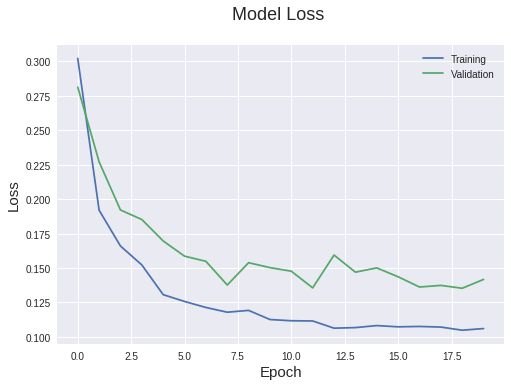

In [0]:
plot_history(descriptor_history_improved)

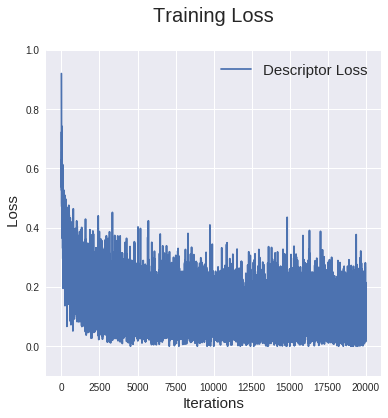

In [0]:
plot_lc(histories_descriptor_improved,
        legstr=['Descriptor Loss'],
        ylimit=[-0.1,1])

In [0]:
# Load the best performing model
# denoise_model_UNet = keras.models.load_model('model_impr-019.h5')
# descriptor_model_improved = keras.models.load_model('model_desc-018.h5')

## Improved descriptor model evaluation

In [0]:
# Generation of the .csv file and samples for the descriptor model evaluation
generate_desc_csv(descriptor_model_improved, seqs_test, denoise_model=denoise_model_UNet, use_clean=False)

100%|██████████| 40/40 [18:50<00:00, 26.15s/it]


### Verification

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification --more_info


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:23<00:00, 11933.43it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:25<00:00, 11678.49it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:26<00:00, 11611.67it/s]
>> Verification task finished in 262 secs  
Verification task results:
CUSTOM - Imbalanced variant (ap) 
Noise       Inter     Intra
-------  --------  --------
Easy     0.895362  0.825782
Hard     0.855563  0.760994
Tough    0.791495  0.674044
Mean Average Precision is 0.800540


### Matching

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching --more_info


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [01:45<00:00,  3.56s/it]
>> Matching task finished in 105 secs  
Matching task results:
CUSTOM - mAP 
    Easy      Hard      Tough      mean
--------  --------  ---------  --------
0.276777  0.132846  0.0568122  0.155479
Mean Average Precision is 0.155479




### Retrieval

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval --more_info


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x26ecc000 @  0x7f884db261e7 0x7f88433d1a41 0x7f8843434c13 0x7f884343699e 0x7f88434ce748 0x5030d5 0x507641 0x504c28 0x502540 0x502f3d 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x506393 0x634d52 0x634e0a 0x6385c8 0x63915a 0x4a6f10 0x7f884d723b97 0x5afa0a
>> Distance matrix done.
Processing retrieval task: 100% 10000/10000 [03:09<00:00, 52.77it/s]
>> Retrieval task finished in 204 secs  
Retrieval task results:
CUSTOM - mAP 10K queries 
Noise         100       500      1000      5000     10000     15000     20000
-------  --------  --------  --------  --------  --------  --------  --------
Easy     0.814644  0.683041  0.630405  0.507341  0.458383  0.430877  0.413397
Hard     0.772581  0.603584  0.532035  0.373714  0.3127

## Exporting .csv files
This will be done for the final competition submission next week.